In [25]:
from pathlib import Path
import torch
import mido
import pypianoroll
from tqdm.auto import tqdm

In [26]:
midi_fns = sorted(list(Path('data/midi-original/AD2/').glob('*.mid')))

[<Axes: xlabel='time (beat)', ylabel='Addictive Drums 2 x64 1\n\npitch'>]

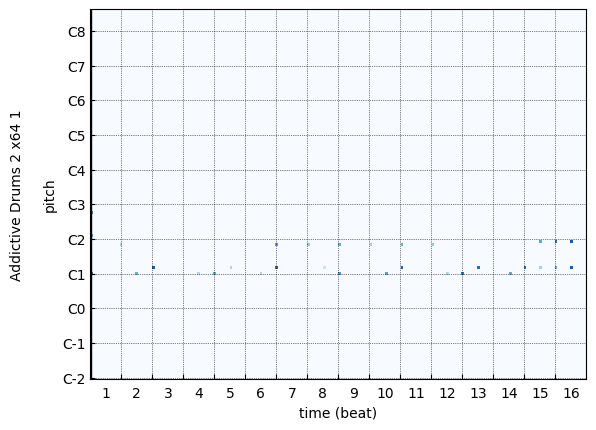

In [77]:
multitrack = pypianoroll.read(midi_fns[12])
multitrack.plot()

In [27]:
# map velocity from -0.5 to 0.5
def map_vel(vel):
    return (vel - 64) / 128

In [28]:
key2idx = {
    36: 0, # Kick
    37: 1, # Side Stick
    38: 2, # Snare
    41: 3, # Floor Tom
    42: 4, # Closed Hat
    43: 5, # Low-Mid Tom
    44: 6, # Pedal Hat
    45: 7, # High-Mid Tom
    46: 8, # Open Hat
    47: 9, # High Tom
    49: 11, # Crash
    51: 13, # Ride
    53: 14, # Ride Bell
}

In [29]:
def midi_to_tensor(midi_fn):
    mid = mido.MidiFile(midi_fn)
    msgs = [msg for msg in mid.tracks[1]]

    msg_list = []
    tick = 0
    for msg in msgs:
        tick += msg.time
        if msg.type == 'note_on' and msg.note in key2idx:
            msg_list.append([tick, key2idx[msg.note], map_vel(msg.velocity)])
        elif msg.type == 'note_on' and msg.note not in key2idx:
            print(f'{midi_fn} contains unknown key: {msg.note}')

    roll_tensor = torch.zeros((15, 1536)) - 0.5
    for msg in msg_list:
        roll_tensor[msg[1], msg[0]] = msg[2]

    return roll_tensor

In [30]:
def convert_midi(midi_fns, output_path):
    for midi_fn in tqdm(midi_fns):
        roll_tensor = midi_to_tensor(midi_fn)
        torch.save(roll_tensor, output_path / f'{midi_fn.stem}.pt')

In [33]:
convert_midi(midi_fns, Path('data/converted'))

  0%|          | 0/146 [00:00<?, ?it/s]